# Checkpoints

In this notebook we will look  at how we can save the stage of a PyTorch model during training and how we can load it back to continue training or to make predictions. We will also look at how we can save the model's state dictionary and load it back to continue training or to make predictions.

To do this we can use the models `state_dict` and the `torch.save` and `torch.load` functions. This allows you to reload the parameters into a different model architecture later, as long as the new architecture is compatible with the saved parameters. 

First we will define a model and toy dataset to train on.


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import sys
sys.path.append('../')
from Utils import get_device,accuracy
device=get_device()

(2000, 2) (2000,)


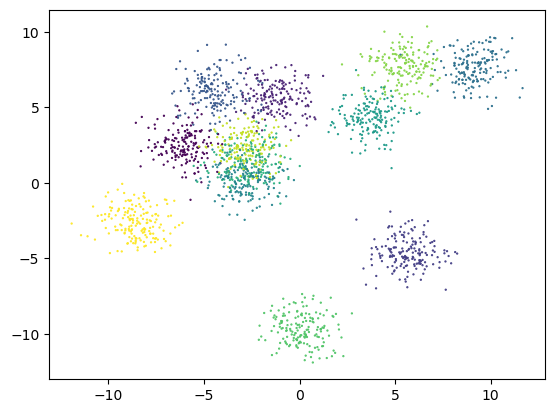

In [22]:
X, y = make_blobs(n_samples=2000, n_features=2,  centers=12, random_state=1234)
print(X.shape, y.shape)
plt.scatter(X[:,0], X[:,1], c=y, s=0.4);


We can use sklearn's test_train_split function to split the data into training and validation sets.

In [23]:
# generate test / train split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
# We can now convert the numpy arrays to PyTorch tensors
X_train = torch.FloatTensor(X_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)


(1340, 2) (1340,)
(660, 2) (660,)


In [24]:
torch.manual_seed(1234)
class Classify(nn.Module):
    def __init__(self,input_features=2,output_features=1,hidden_size=8):
        super().__init__()
        self.linear_layer = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_size),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=hidden_size),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size, out_features=output_features)
        )
    def forward(self, x):
       return self.linear_layer(x)


model = Classify(input_features=2,output_features=12).to(device)
print(model.parameters)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=model.parameters(),lr=0.01)


<bound method Module.parameters of Classify(
  (linear_layer): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=12, bias=True)
  )
)>


We can now do our training, however in this case we will only train for 10 epochs, (which will be quick) then save the model's state dictionary and the entire model. We will then load the model back and continue training for another 10 epochs. 

This is basically simulating a situation where you have a long running training job and you want to save the model's state at certain intervals to avoid losing all the progress if the training job is interrupted.

As we are going to do re-training again, I will write the training loop into a function. 

In [25]:
def train_function(model, X_train, y_train, loss_fn, optimizer, epochs=100, check_every=10):
    for epoch in range(epochs):
        ## Training
        model.train()

        # Forward pass
        y_logits = model(X_train)
        # turn logits -> pred probs -> pred labels
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    
        # Calculate loss/accuracy
        loss = loss_fn(y_logits, y_train) 
        acc = accuracy(y_true=y_train, y_pred=y_pred) 

        # reset the optimizer to zero
        optimizer.zero_grad()
        # calculate the gradients
        loss.backward()
        # update the weights
        optimizer.step()
        if epoch % check_every == 0:
            print(f'Epoch {epoch} loss: {loss.item()} {acc=}')

train_function(model=model, X_train=X_train, y_train=y_train, loss_fn=loss_fn, optimizer=optimizer, epochs=10)

# let's see the final accuracy
## we  can see who accurate the input model is to start with
y_logits = model(X_train)
# turn logits -> pred probs -> pred labels
y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
# Calculate loss/accuracy
acc = accuracy(y_true=y_train, y_pred=y_pred) 
print(f'Accuracy of the final model: {acc}')


Epoch 0 loss: 2.62601375579834 acc=0.6716417910447761
Accuracy of the final model: 1.2686567164179103


As you can see from the first 100 epochs we get low (single digit) accuracy. We will now save the model and load it back to continue training.

To save we use the ```torch.save``` function, it has several options. We can save the entire model, the model's state dictionary, the optimizer's state dictionary, or any combination of these. We can also save to a file or to a buffer.

In [26]:
torch.save(model.state_dict(), 'checkpoint1.pth')

No we can build a new instance of the model and load the state dictionary back into it. We can then continue training.

In [27]:
new_model = Classify(input_features=2,output_features=12).to(device)
new_model.load_state_dict(torch.load('checkpoint1.pth'),strict=True)

## we  can see who accurate the input model is to start with
y_logits = new_model(X_train)
# turn logits -> pred probs -> pred labels
y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
# Calculate loss/accuracy
acc = accuracy(y_true=y_train, y_pred=y_pred) 
print(f'Accuracy of the loaded model: {acc}')

# also update the hyperparameters
optimizer = optim.SGD(params=new_model.parameters(),lr=0.25)


# now we can do some more training
train_function(model=new_model, X_train=X_train, y_train=y_train, loss_fn=loss_fn, optimizer=optimizer, epochs=800,check_every=100)



Accuracy of the loaded model: 1.2686567164179103
Epoch 0 loss: 2.5226519107818604 acc=1.2686567164179103
Epoch 100 loss: 0.7277879118919373 acc=68.05970149253731
Epoch 200 loss: 0.5519075989723206 acc=78.35820895522389
Epoch 300 loss: 0.48749709129333496 acc=77.91044776119404
Epoch 400 loss: 0.4247775375843048 acc=81.7910447761194
Epoch 500 loss: 0.36299610137939453 acc=83.88059701492537
Epoch 600 loss: 0.3591786324977875 acc=83.65671641791045
Epoch 700 loss: 0.4300985336303711 acc=80.67164179104478


In the above model we instantiate a new model and load the state dictionary back into it. We can then continue training. We use the ```strict=True``` option to ensure that the keys in the state dictionary match the keys in the model. If they don't match, an error will be raised.

# Full Model Save and Load

It is also possible to save and load the full model. You must still have the model's class definition available when you load the model back. This is because the model's class definition is used to instantiate the model when it is loaded back.

In [28]:
torch.save(new_model, 'checkpoint2.pth')

full_model = torch.load('checkpoint2.pth')

## we  can see who accurate the input model is to start with
y_logits = full_model(X_train)
# turn logits -> pred probs -> pred labels
y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
# Calculate loss/accuracy
acc = accuracy(y_true=y_train, y_pred=y_pred)
print(f'Accuracy of the loaded model: {acc}')

Accuracy of the loaded model: 84.32835820895522


# Tips for Flexibility in Changing Architecture

Parameter Mapping: If the new architecture requires a different mapping of parameters, you may need to selectively load parameters by modifying the state_dict, below I have a new model with a different architecture, I will show how to load the state dictionary into it.

In [29]:
class ClassifyELU(nn.Module):
    def __init__(self,input_features=2,output_features=1,hidden_size=8):
        super().__init__()
        self.linear_layer = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=8),
            nn.ELU(),
            nn.Linear(in_features=8, out_features=hidden_size//2),
            nn.ELU(),
            nn.Linear(in_features=hidden_size//2, out_features=hidden_size//2),
            nn.ELU(),
            nn.Linear(in_features=hidden_size//2, out_features=output_features))
        
    def forward(self, x):
       return self.linear_layer(x)


model_elu = ClassifyELU(input_features=2,output_features=12).to(device)
try :
    model_elu.load_state_dict(torch.load('checkpoint1.pth'),strict=False)
except :
    print('Failed to load the model')


Failed to load the model



As you can see loading this model doesn't work as it has a different architecture. We can fix this by loading the state dictionary then transferring the parameters to the new model.

In [30]:
# Transfer weights
def transfer_weights(loaded_model, new_model):
    loaded_state_dict = loaded_model.state_dict()
    new_state_dict = new_model.state_dict()

    for name, param in loaded_state_dict.items():
        if name in new_state_dict:
            if new_state_dict[name].size() == param.size():
                new_state_dict[name].copy_(param)
            else:
                print(f"Skipping {name} due to size mismatch.")
        else:
            print(f"Skipping {name} as it is not in the new model.")

    new_model.load_state_dict(new_state_dict)

loaded_model = torch.load('checkpoint2.pth')

transfer_weights(loaded_model, model_elu)




Skipping linear_layer.2.weight due to size mismatch.
Skipping linear_layer.2.bias due to size mismatch.
Skipping linear_layer.4.weight due to size mismatch.
Skipping linear_layer.4.bias due to size mismatch.


## Use Cases for Changing Architectures

- Fine-tuning: Add or replace layers to adapt the model for a new task.
- Model Compression: Prune or reduce the number of layers to make the model lighter.
- Transfer Learning: Load pre-trained weights into a similar architecture.

By saving and loading the state_dict, you maintain flexibility to adapt the architecture while preserving the previously learned parameters.

# Conclusion

In this notebook we have seen how to save and load the state of a PyTorch model during training. We have seen how to save and load the model's state dictionary and how to load the state dictionary into a new model with a different architecture. This allows you to save the state of a model during training and load it back to continue training or to make predictions.